In [1]:
# Goals:
#     - Get the puffer data in
#     - Understand the puffer paper
#     - Train Random Forest on the puffer data based on Richard's work

In [2]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset folders
dataset_list = ['video_sent_2025-05-19T11_2025-05-20T11']

current_dir = os.getcwd()
base_path = '' + current_dir + '/puffer_tests/'
print(base_path)
# base_path = './test_data'

# Quality labels to predict
quality_labels = ['144', '240', '360', '480', '720', '1080', '1440', '2160']

# Collect all merged CSVs
all_dfs = []
print("Loading CSV files...")
for dataset in tqdm(dataset_list, desc="Datasets"):
    file_path = os.path.join(base_path + dataset + '.csv')  # <-- match all CSVs
    
    try:
        df = pd.read_csv(file_path, dtype=str)
        print(f"Loaded {file_path} with shape {df.shape}")
        df['source_dataset'] = dataset  # Optional: keep track of source
        all_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
# # Combine all data

/Users/stevenjiang/Documents/GitHub/293N-YT-ABR-Prediction/puffer_tests/
Loading CSV files...


Datasets: 100%|██████████| 1/1 [00:18<00:00, 18.66s/it]

Loaded /Users/stevenjiang/Documents/GitHub/293N-YT-ABR-Prediction/puffer_tests/video_sent_2025-05-19T11_2025-05-20T11.csv with shape (4440577, 16)


In [3]:
print(all_dfs)

[               time (ns GMT)                                    session_id  \
0        1747652401422000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
1        1747652402461000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
2        1747652403339000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
3        1747652404440000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
4        1747652405154000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
...                      ...                                           ...   
4440572  1747730064822000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440573  1747730065759000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440574  1747730066515000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440575  1747730066964000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440576  1747730068026000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   

        index expt_id channel     video_ts        format    si

In [4]:
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")
print(data.columns)

Combining CSVs into one DataFrame...
Total rows loaded: 4440577
Index(['time (ns GMT)', 'session_id', 'index', 'expt_id', 'channel',
       'video_ts', 'format', 'size', 'ssim_index', 'cwnd', 'in_flight',
       'min_rtt', 'rtt', 'delivery_rate', 'buffer', 'cum_rebuf',
       'source_dataset'],
      dtype='object')


In [5]:
quality_to_index = {q: i for i, q in enumerate(quality_labels)}

def extract_first_number(s):
    return s.split('x')[1].split('-')[0]

#data['PlaybackQuality'] = df_numeric.idxmax(axis=1).map(quality_to_index)

df_numeric = data[['format']].applymap(lambda x: extract_first_number(x))
#df_numeric
data['PlaybackQuality'] = df_numeric['format'].map(quality_to_index)



In [6]:
print("Filtering out rows with no quality label...")
data = data.dropna(subset=['PlaybackQuality'])

Filtering out rows with no quality label...


In [7]:
data

,time (ns GMT),session_id,index,expt_id,channel,video_ts,format,size,ssim_index,cwnd,in_flight,min_rtt,rtt,delivery_rate,buffer,cum_rebuf,source_dataset,PlaybackQuality
0,1747652401422000000,B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=,0,2216,abc,96469813440,1280x720-20,348654,0.992165,146,0,79000,292279,418852,9.802,0.792,video_sent_2025-05-19T11_2025-05-20T11,4
1,1747652402461000000,B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=,0,2216,abc,96469993620,1280x720-20,307381,0.991513,170,25,79000,283970,409160,10.765,0.792,video_sent_2025-05-19T11_2025-05-20T11,4
2,1747652403339000000,B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=,0,2216,abc,96470173800,1280x720-20,287007,0.990341,170,0,79000,290337,485477,11.89,0.792,video_sent_2025-05-19T11_2025-05-20T11,4
3,1747652404440000000,B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=,0,2216,abc,96470353980,1280x720-22,105047,0.993485,170,12,79000,296329,414979,12.791,0.792,video_sent_2025-05-19T11_2025-05-20T11,4
4,1747652405154000000,B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=,0,2216,abc,96470534160,1280x720-24,54548,0.993215,162,0,79000,310231,240420,14.079,0.792,video_sent_2025-05-19T11_2025-05-20T11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440572,1747730064822000000,C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=,4,2223,pbs,37049332320,1280x720-20,761602,0.978803,254,27,157038,166777,848821,10.137,0.291,video_sent_2025-05-19T11_2025-05-20T11,4
4440573,1747730065759000000,C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=,4,2223,pbs,37049512500,1920x1080-24,728831,0.980852,286,0,157038,164948,1096766,11.204,0.291,video_sent_2025-05-19T11_2025-05-20T11,5
4440574,1747730066515000000,C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=,4,2223,pbs,37049692680,1920x1080-24,376002,0.977132,352,21,156073,165638,1335244,12.448,0.291,video_sent_2025-05-19T11_2025-05-20T11,5
4440575,1747730066964000000,C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=,4,2223,pbs,37049872860,1920x1080-22,432545,0.98092,350,0,154526,164379,1316935,14.003,0.291,video_sent_2025-05-19T11_2025-05-20T11,5


In [8]:
# Wrap in tqdm for progress bar
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    data[col] = pd.to_numeric(data[col], errors='ignore')
print(data)

Converting columns to numeric: 100%|██████████| 18/18 [00:32<00:00,  1.78s/it]

               time (ns GMT)                                    session_id  \
0        1747652401422000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
1        1747652402461000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
2        1747652403339000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
3        1747652404440000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
4        1747652405154000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
...                      ...                                           ...   
4440572  1747730064822000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440573  1747730065759000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440574  1747730066515000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440575  1747730066964000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440576  1747730068026000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   

         index  expt_id channel     video_ts        format    s

In [9]:
# Drop original quality columns
data = data.drop(columns=['format'])
print(data)
# # Drop non-numeric BECAUSE RF DOESNT WORK ON NON NUMERICS
# non_feature_cols = ['IPSrc0', 'IPDst0', 'Protocol0', 'source_dataset',
#                     'CollectData', 'StartTime', 'UnlabelledQuality']
# data = data.drop(columns=[col for col in non_feature_cols if col in data.columns], errors='ignore')

# # Remove IP and protocol columns (non-numeric)
# data = data[[col for col in data.columns if not any(proto in col for proto in ['IPSrc', 'IPDst', 'Protocol'])]]

# Drop any remaining non-numeric columns
data = data.select_dtypes(include=['number', 'bool'])
print(data)

               time (ns GMT)                                    session_id  \
0        1747652401422000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
1        1747652402461000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
2        1747652403339000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
3        1747652404440000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
4        1747652405154000000  B9FX9GRZgwn32Vqzw4tHgR2Xn+AnRPVIRTg9RvrxZC0=   
...                      ...                                           ...   
4440572  1747730064822000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440573  1747730065759000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440574  1747730066515000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440575  1747730066964000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   
4440576  1747730068026000000  C+kmcRJUwenRw/58Sx+6hly75v3hcJxhZh8vcOM1B0o=   

         index  expt_id channel     video_ts    size  ssim_inde

In [10]:
# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']


In [11]:
print(y)
print(X)

0          3
1          3
2          3
3          3
4          3
          ..
4440572    3
4440573    4
4440574    4
4440575    4
4440576    4
Name: PlaybackQuality, Length: 4440577, dtype: int64
               time (ns GMT)  index  expt_id     video_ts    size  ssim_index  \
0        1747652401422000000      0     2216  96469813440  348654    0.992165   
1        1747652402461000000      0     2216  96469993620  307381    0.991513   
2        1747652403339000000      0     2216  96470173800  287007    0.990341   
3        1747652404440000000      0     2216  96470353980  105047    0.993485   
4        1747652405154000000      0     2216  96470534160   54548    0.993215   
...                      ...    ...      ...          ...     ...         ...   
4440572  1747730064822000000      4     2223  37049332320  761602    0.978803   
4440573  1747730065759000000      4     2223  37049512500  728831    0.980852   
4440574  1747730066515000000      4     2223  37049692680  376002    0.9771

In [12]:

# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
for i in tqdm(range(1), desc="Training"):
    clf.fit(X_train, y_train)

# Evaluate
print("\nEvaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...


Training: 100%|██████████| 1/1 [02:43<00:00, 163.64s/it]



Evaluating model...


In [13]:
print(le.classes_.astype(str))

['1' '2' '3' '4' '5']



Classification Report:


/Users/stevenjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stevenjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stevenjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.91      0.95      0.93      9805
           3       0.58      0.41      0.48      3535
           4       0.67      0.59      0.63      9253
           5       0.98      0.97      0.98    369761

   micro avg       0.97      0.96      0.96    392354
   macro avg       0.63      0.58      0.60    392354
weighted avg       0.97      0.96      0.96    392354



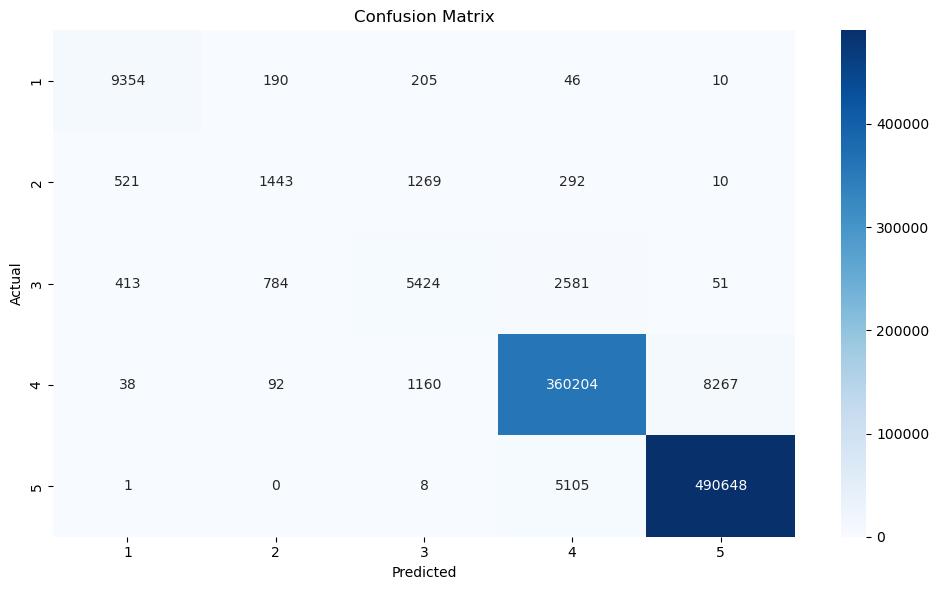

In [14]:
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=le.classes_))
# Convert the integer labels back to string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

# Classification report with string labels
print("\nClassification Report:")
print(classification_report(y_test_str, y_pred_str, labels=range(len(le.classes_)), target_names=le.classes_.astype(str)))
# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [15]:
from trustee import ClassificationTrustee

# Apply ClassificationTrustee
trustee = ClassificationTrustee(expert=clf)

# Fit the trustee model to the training data
trustee.fit(X_train, y_train, num_iter=2, num_stability_iter=2, samples_size=0.3, verbose=True)

# Get the explanation (decision tree and other metrics)
dt, pruned_dt, agreement, reward = trustee.explain()

# Predict using the pruned decision tree
dt_y_pred = dt.predict(X_test)

# Print the global fidelity report
print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))

# Print the explanation score report
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(n_estimators=10, random_state=42) as expert model
Expert model score: 0.9943253672559174
Initializing Trustee outer-loop with 2 iterations
########## Outer-loop Iteration 0/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 746016 points from training dataset with (2486722, 2486722) entries
Student model 0-0 trained with depth 41 and 18976 leaves:
Student model score: 0.7303113214936595
Student model 0-0 fidelity: 0.7303113214936595
########## Inner-loop Iteration 1/2 ##########
Sampling 746016 points from training dataset with (2710527, 2710527) entries
Student model 0-1 trained with depth 40 and 18141 leaves:
Student model score: 0.7368707182557931
Student model 0-1 fidelity: 0.7368707182557931
########## Outer-loop Iteration 1/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 746016 points 

/Users/stevenjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     10327
           1       0.29      0.41      0.34      2509
           2       0.49      0.55      0.52      8066
           3       0.95      0.96      0.96    368228
           4       0.98      0.97      0.97    498986

    accuracy                           0.96    888116
   macro avg       0.72      0.75      0.74    888116
weighted avg       0.96      0.96      0.96    888116

Model explanation score report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      9805
           1       0.36      0.36      0.36      3535
           2       0.49      0.49      0.49      9253
           3       0.95      0.95      0.95    369761
           4       0.97      0.97      0.97    495762

    accuracy                           0.95    888116
   macro avg       0.73      0.73      0.73    888116
wei

In [ ]:
# This one might actually work?
from trustee.report.trust import TrustReport

OUTPUT_PATH = "./test"

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

target_names = [str(name) for name in y.unique()]  # Convert target labels to strings
feature_names = X.columns.tolist()  # Feature column names

trust_report = TrustReport(
    clf,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    max_iter=1,
    num_pruning_iter=1,
    train_size=0.7,
    trustee_num_iter=1,
    trustee_num_stability_iter=1,
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=1,
    verbose=True,
    class_names=target_names,
    feature_names=feature_names,
    is_classify=True,
)

print(trust_report)
trust_report.save(OUTPUT_PATH)

Running Trust Report...
Preparing data...
Done!
Progress |----------------------------------------------------------------------------------------------------| 0.9% Complete
Done!
Progress |█---------------------------------------------------------------------------------------------------| 1.8% Complete
Fitting blackbox model...
Done!
Blackbox model score report with training data:

              precision    recall  f1-score   support

           0      0.910     0.955     0.932     14755
           1      0.568     0.421     0.484      5263
           2      0.674     0.597     0.634     13862
           3      0.977     0.973     0.975    554776
           4      0.983     0.989     0.986    743518

    accuracy                          0.976   1332174
   macro avg      0.823     0.787     0.802   1332174
weighted avg      0.975     0.976     0.975   1332174

Using Classification Trustee algorithm to extract DT...
Initializing training dataset using RandomForestClassifier(n_estimat